In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CALCULO DE DISTANCIAS Y TIEMPOS DE RECORRIDO

In [2]:
import pandas as pd
import numpy as np
import math
df = pd.read_csv("/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_alopuno_25k.csv")
coords = set()

for _, row in df.iterrows():
    try:
        lat1, lon1 = map(float, row['Coordenadas Origen'].split(','))
        lat2, lon2 = map(float, row['Coordenadas Destino'].split(','))
        coords.add((lat1, lon1))
        coords.add((lat2, lon2))
    except:
        pass

num_nodos = len(coords)

def haversine(lat1, lon1, lat2, lon2):
    if lat1 == lat2 and lon1 == lon2:
        return 0.0
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    return 2 * math.asin(math.sqrt(a)) * 6371

def ajustar_distancia(distancia, minimo=0.8):
    if distancia < 1:
        factor = np.random.uniform(1.18, 1.35)
    elif distancia < 5:
        factor = np.random.uniform(1.28, 1.42)
    elif distancia < 15:
        factor = np.random.uniform(1.15, 1.23)
    else:
        factor = np.random.uniform(1.08, 1.13)
    distancia_ajustada = distancia * factor
    return round(max(distancia_ajustada, minimo), 2)

def estimar_tiempo(distancia_km):
    if distancia_km < 1:
        velocidad = np.random.uniform(16, 22)
    elif distancia_km < 3:
        velocidad = np.random.uniform(16, 22)
    elif distancia_km < 7:
        velocidad = np.random.uniform(18, 26)
    elif distancia_km < 15:
        velocidad = np.random.uniform(20, 28)
    else:
        velocidad = np.random.uniform(26, 35)

    tiempo_min = (distancia_km / velocidad) * 60

    tiempo_min *= np.random.uniform(1.05, 1.18)

    if tiempo_min < 2.5:
        tiempo_min = np.random.uniform(3.2, 5)

    return round(tiempo_min, 2)

def calcular_distancia_y_tiempo(row):
    try:
        lat1, lon1 = map(float, row['Coordenadas Origen'].split(','))
        lat2, lon2 = map(float, row['Coordenadas Destino'].split(','))
    except Exception:
        return pd.Series([np.nan, np.nan])

    distancia_hav = haversine(lat1, lon1, lat2, lon2)
    distancia_ajustada = ajustar_distancia(distancia_hav)
    tiempo_estimado = estimar_tiempo(distancia_ajustada)
    return pd.Series([distancia_ajustada, tiempo_estimado])

df[['Distancia (km)', 'Tiempo de Viaje (min)']] = df.apply(calcular_distancia_y_tiempo, axis=1)

output_path = "/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_alopuno_25k_dist_tiempo.csv"
df.to_csv(output_path, index=False)

print("\nResumen estadístico:")
print(df[['Distancia (km)', 'Tiempo de Viaje (min)']].describe())


Resumen estadístico:
       Distancia (km)  Tiempo de Viaje (min)
count    25000.000000           25000.000000
mean         2.749282               8.844104
std          2.036872               5.903594
min          0.800000               2.500000
25%          1.000000               3.670000
50%          2.050000               7.290000
75%          3.950000              12.160000
max         11.880000              39.240000


In [4]:
df['Nodo_Origen'] = df['Coordenadas Origen'].str.strip()
df['Nodo_Destino'] = df['Coordenadas Destino'].str.strip()

nodos = pd.Index(
    pd.concat([df['Nodo_Origen'], df['Nodo_Destino']]).unique(),
    name="Nodo"
)

coord_dict = {
    nodo: tuple(map(float, nodo.split(',')))
    for nodo in nodos
}

n = len(nodos)
matriz_distancias = np.zeros((n, n))

for i, nodo_i in enumerate(nodos):
    lat1, lon1 = coord_dict[nodo_i]
    for j, nodo_j in enumerate(nodos):
        if i == j:
            continue
        lat2, lon2 = coord_dict[nodo_j]
        matriz_distancias[i, j] = haversine(lat1, lon1, lat2, lon2)

coord_to_name = {}

for _, row in df[['Lugar de Origen', 'Coordenadas Origen']].drop_duplicates().iterrows():
    coord_to_name[row['Coordenadas Origen']] = row['Lugar de Origen']

for _, row in df[['Lugar de Destino', 'Coordenadas Destino']].drop_duplicates().iterrows():
    coord_to_name[row['Coordenadas Destino']] = row['Lugar de Destino']

labels_nombres = [coord_to_name.get(c, c) for c in nodos]

matriz_dist_df = pd.DataFrame(matriz_distancias, index=labels_nombres, columns=labels_nombres)

print("Matriz de distancias creada con nombres.")

Matriz de distancias creada con nombres.


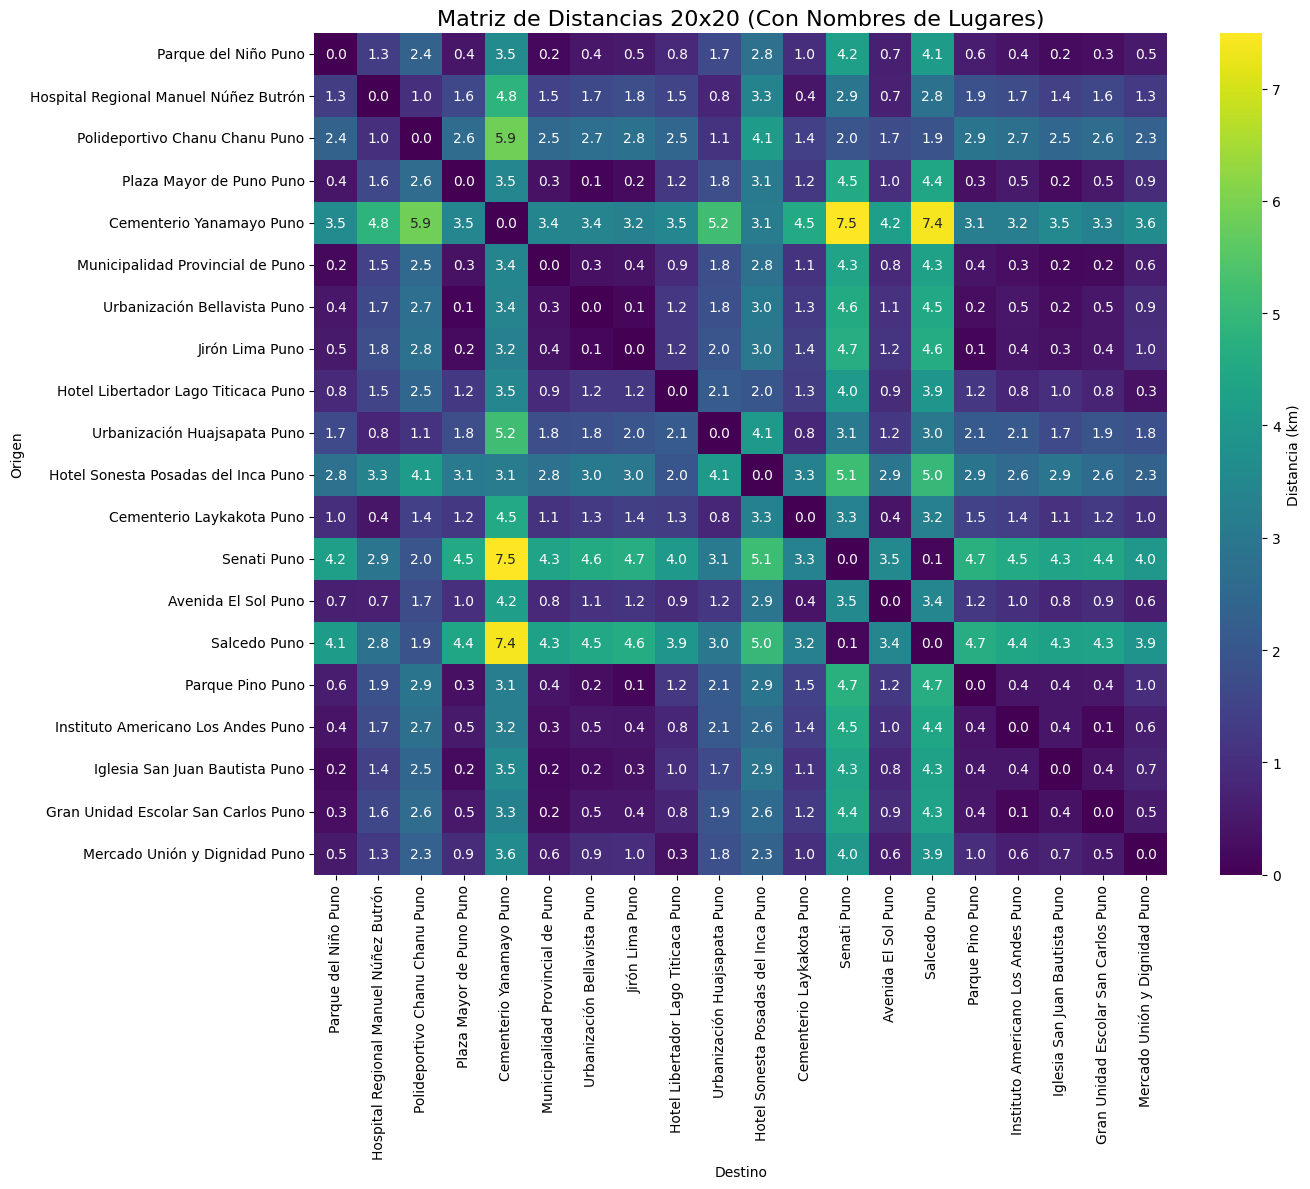

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

if len(nodos) >= 20:
    labels_20 = labels_nombres[:20]
    matriz_20 = matriz_dist_df.loc[labels_20, labels_20]

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        matriz_20,
        annot=True,
        fmt=".1f",
        cmap="viridis",
        cbar_kws={"label": "Distancia (km)"}
    )
    plt.title("Matriz de Distancias 20x20 (Con Nombres de Lugares)", fontsize=16)
    plt.xlabel("Destino")
    plt.ylabel("Origen")
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes nodos para generar una matriz 20x20.")

matriz_distancias = matriz_distancias.astype(float)

num_lugares = matriz_distancias.shape[0]

dist_prom_real = df["Distancia (km)"].mean()
peso_hav = 0.7
peso_real = 0.3

for i in range(num_lugares):
    for j in range(num_lugares):
        if i != j:
            d_hav = matriz_distancias[i, j]
            matriz_distancias[i, j] = (peso_hav * d_hav) + (peso_real * dist_prom_real)

matriz_tiempos = np.zeros((n, n))

for i, nodo_i in enumerate(nodos):
    df_i = df[df["Nodo_Origen"] == nodo_i]
    for j, nodo_j in enumerate(nodos):
        if i == j:
            continue

        df_ij = df_i[df_i["Nodo_Destino"] == nodo_j]

        if len(df_ij) > 0:
            matriz_tiempos[i, j] = df_ij["Tiempo de Viaje (min)"].mean()
        else:
            d_hav = matriz_distancias[i, j]
            matriz_tiempos[i, j] = estimar_tiempo(d_hav)

dist_norm = matriz_distancias / matriz_distancias.max()
tiempo_norm = matriz_tiempos / matriz_tiempos.max()

peso_dist = 0.6
peso_tiempo = 0.4

matriz_hibrida = (peso_dist * dist_norm) + (peso_tiempo * tiempo_norm)

# APLICACIÓN DE ALGORITMOS

In [6]:
parametros = {
    "ACO": {
        "explorador": {"hormigas": 55, "iters": 260, "evap": 0.3, "alfa": 1,   "beta": 2},
        "explotador": {"hormigas": 30, "iters": 180, "evap": 0.65, "alfa": 2,   "beta": 5},
        "balanceado": {"hormigas": 40, "iters": 220, "evap": 0.5, "alfa": 1.5, "beta": 3}
    },
    "TS": {
        "explorador": {"tabu": 450, "iters": 1400, "vecinos": 1300},
        "explotador": {"tabu": 160, "iters": 700,  "vecinos": 700},
        "balanceado": {"tabu": 300, "iters": 1000, "vecinos": 1000}
    },
    "GA": {
        "explorador": {"gens": 500, "pob": 300, "mut": 0.15},
        "explotador": {"gens": 260, "pob": 160, "mut": 0.07},
        "balanceado": {"gens": 380, "pob": 230, "mut": 0.10}
    }
}


In [7]:
import numpy as np
import time

def algoritmo_aco(matriz_distancias, matriz_tiempos,
                  num_hormigas=40, num_iteraciones=220,
                  evaporacion=0.5, alfa=1.5, beta=3):

    num_lugares = matriz_distancias.shape[0]
    t0 = time.time()

    valor_inicial = 1 / (num_lugares * matriz_distancias.mean())
    feromonas = np.ones((num_lugares, num_lugares)) * valor_inicial

    def seleccionar(nodo_actual, visitados):
        atractivos = np.zeros(num_lugares)
        for j in range(num_lugares):
            if j not in visitados and matriz_distancias[nodo_actual][j] > 0:
                tau = feromonas[nodo_actual][j] ** alfa
                eta = (1 / matriz_distancias[nodo_actual][j]) ** beta
                atractivos[j] = tau * eta

        total = atractivos.sum()
        if total == 0:
            return np.random.choice([j for j in range(num_lugares) if j not in visitados])

        prob = atractivos / total
        return np.random.choice(range(num_lugares), p=prob)

    mejor_ruta = None
    mejor_distancia = float("inf")

    for _ in range(num_iteraciones):
        for _ in range(num_hormigas):

            nodo_actual = np.random.randint(0, num_lugares)
            ruta = [nodo_actual]
            distancia_total = 0

            while len(ruta) < num_lugares:
                sig = seleccionar(nodo_actual, ruta)
                distancia_total += matriz_distancias[nodo_actual][sig]
                ruta.append(sig)
                nodo_actual = sig

            deposito = 1 / distancia_total
            for i in range(len(ruta) - 1):
                feromonas[ruta[i]][ruta[i + 1]] += deposito

            if distancia_total < mejor_distancia:
                mejor_distancia = distancia_total
                mejor_ruta = ruta

        feromonas *= (1 - evaporacion)

    segmentos_dist = [
        matriz_distancias[mejor_ruta[i]][mejor_ruta[i + 1]]
        for i in range(len(mejor_ruta) - 1)
    ]

    segmentos_tiempo = [
        matriz_tiempos[mejor_ruta[i]][mejor_ruta[i + 1]]
        for i in range(len(mejor_ruta) - 1)
    ]

    dist_real_promedio = round(np.mean(matriz_distancias[matriz_distancias > 0]), 2)
    tiempo_real_promedio = round(np.mean(matriz_tiempos[matriz_tiempos > 0]), 2)
    distancia_promedio_opt = np.mean(segmentos_dist)
    desviacion_dist = np.std(segmentos_dist)
    tiempo_promedio_opt = np.mean(segmentos_tiempo)
    desviacion_tiempo = np.std(segmentos_tiempo)

    tiempo_ejecucion = round(time.time() - t0, 3)

    return {
        "Distancia Promedio Real (km)": dist_real_promedio,
        "Tiempo Promedio Real (min)": tiempo_real_promedio,

        "Distancia Promedio Optimizada (km)": round(distancia_promedio_opt, 2),
        "Desviación Estándar Distancia Optimizada (km)": round(desviacion_dist, 2),

        "Tiempo Promedio Optimizado (min)": round(tiempo_promedio_opt, 2),
        "Desviación Estándar Tiempo Optimizado (min)": round(desviacion_tiempo, 2),

        "Tiempo de Ejecución (s)": tiempo_ejecucion,
        "Ruta Óptima": mejor_ruta,
    }


In [8]:
modo = "balanceado"
config = parametros["ACO"][modo]

resultados_aco = algoritmo_aco(
    matriz_distancias,
    matriz_tiempos,
    num_hormigas=config["hormigas"],
    num_iteraciones=config["iters"],
    evaporacion=config["evap"],
    alfa=config["alfa"],
    beta=config["beta"]
)

print("\n=== Resultados ACO ===")
for k, v in resultados_aco.items():
    if k == "Ruta Óptima":
        ruta_nombres = [labels_nombres[i] for i in v]
        print(f"{k}: {ruta_nombres}")
    else:
        print(f"{k}: {v}")


=== Resultados ACO ===
Distancia Promedio Real (km): 2.25
Tiempo Promedio Real (min): 8.6
Distancia Promedio Optimizada (km): 1.22
Desviación Estándar Distancia Optimizada (km): 0.42
Tiempo Promedio Optimizado (min): 3.97
Desviación Estándar Tiempo Optimizado (min): 2.06
Tiempo de Ejecución (s): 72.385
Ruta Óptima: ['Isla Esteves Puno', 'Hotel Sonesta Posadas del Inca Puno', 'Universidad Nacional del Altiplano', 'Avenida Floral Puno', 'Mirador Puma Uta Puno', 'Cementerio Yanamayo Puno', 'Urbanización Alto Puno', 'Avenida La Torre Puno', 'Mercado Central Bellavista Puno', 'Plazuela Santa Rosa Puno', 'Plazuela 15 de Agosto Puno', 'Parque Mariátegui Puno', 'Instituto Americano Los Andes Puno', 'Colegio Glorioso San Carlos Puno', 'Colegio Adventista Puno', 'Parque Pino Puno', 'Colegio María Auxiliadora Puno', 'Jirón Lima Puno', 'Urbanización Bellavista Puno', 'Plaza Mayor de Puno Puno', 'Catedral Basílica de Puno', 'Gobierno Regional de Puno', 'Iglesia San Juan Bautista Puno', 'Parque del

In [9]:
def busqueda_tabu(matriz_distancias, matriz_tiempos,
                  tamaño_tabu=300, num_iteraciones=1000,
                  num_vecinos=1000):

    num_lugares = matriz_distancias.shape[0]
    t0 = time.time()

    mejor_ruta = np.random.permutation(num_lugares).tolist()

    def calcular_costo(ruta):
        return sum(matriz_distancias[ruta[i]][ruta[i + 1]] for i in range(len(ruta) - 1))

    mejor_costo = calcular_costo(mejor_ruta)
    ruta_actual = mejor_ruta.copy()
    costo_actual = mejor_costo

    lista_tabu = []

    for _ in range(num_iteraciones):
        mejores_vecinos = []

        for _ in range(num_vecinos):
            a, b = np.random.choice(num_lugares, 2, replace=False)
            vecino = ruta_actual.copy()
            vecino[a], vecino[b] = vecino[b], vecino[a]
            movimiento = (a, b)

            if movimiento not in lista_tabu:
                costo_vecino = calcular_costo(vecino)
                mejores_vecinos.append((vecino, costo_vecino, movimiento))

        if not mejores_vecinos:
            continue

        vecino, costo_vecino, movimiento = min(mejores_vecinos, key=lambda x: x[1])

        ruta_actual = vecino
        costo_actual = costo_vecino

        lista_tabu.append(movimiento)
        if len(lista_tabu) > tamaño_tabu:
            lista_tabu.pop(0)

        if costo_actual < mejor_costo:
            mejor_costo = costo_actual
            mejor_ruta = ruta_actual.copy()

    segmentos_dist = [
        matriz_distancias[mejor_ruta[i]][mejor_ruta[i + 1]]
        for i in range(len(mejor_ruta) - 1)
    ]

    segmentos_tiempo = [
        matriz_tiempos[mejor_ruta[i]][mejor_ruta[i + 1]]
        for i in range(len(mejor_ruta) - 1)
    ]

    dist_real_promedio = round(np.mean(matriz_distancias[matriz_distancias > 0]), 2)
    tiempo_real_promedio = round(np.mean(matriz_tiempos[matriz_tiempos > 0]), 2)

    distancia_promedio_opt = np.mean(segmentos_dist)
    desviacion_dist = np.std(segmentos_dist)
    tiempo_promedio_opt = np.mean(segmentos_tiempo)
    desviacion_tiempo = np.std(segmentos_tiempo)

    tiempo_ejecucion = round(time.time() - t0, 3)

    return {
        "Distancia Promedio Real (km)": dist_real_promedio,
        "Tiempo Promedio Real (min)": tiempo_real_promedio,

        "Distancia Promedio Optimizada (km)": round(distancia_promedio_opt, 2),
        "Desviación Estándar Distancia Optimizada (km)": round(desviacion_dist, 2),

        "Tiempo Promedio Optimizado (min)": round(tiempo_promedio_opt, 2),
        "Desviación Estándar Tiempo Optimizado (min)": round(desviacion_tiempo, 2),

        "Tiempo de Ejecución (s)": tiempo_ejecucion,
        "Ruta Óptima": mejor_ruta
    }


In [10]:
modo = "balanceado"
config_ts = parametros["TS"][modo]

resultados_ts = busqueda_tabu(
    matriz_distancias,
    matriz_tiempos,
    tamaño_tabu=config_ts["tabu"],
    num_iteraciones=config_ts["iters"],
    num_vecinos=config_ts["vecinos"]
)

print("\n=== Resultados TS ===")
for k, v in resultados_ts.items():
    if k == "Ruta Óptima":
        ruta_nombres = [labels_nombres[i] for i in v]
        print(f"{k}: {ruta_nombres}")
    else:
        print(f"{k}: {v}")


=== Resultados TS ===
Distancia Promedio Real (km): 2.25
Tiempo Promedio Real (min): 8.6
Distancia Promedio Optimizada (km): 1.34
Desviación Estándar Distancia Optimizada (km): 0.62
Tiempo Promedio Optimizado (min): 4.61
Desviación Estándar Tiempo Optimizado (min): 2.86
Tiempo de Ejecución (s): 58.473
Ruta Óptima: ['Jayllihuaya Puno', 'Urbanización Salcedo Puno', 'Urbanización Huajsapata Puno', 'Hostal Mirador Korichasca Puno', 'Mirador Kuntur Wasi Puno', 'Complejo Deportivo Alto Llavini Puno', 'Mercado Unión y Dignidad Puno', 'Hotel Libertador Lago Titicaca Puno', 'Avenida Floral Puno', 'Universidad Nacional del Altiplano', 'Estadio Enrique Torres Belón', 'Plazuela 15 de Agosto Puno', 'Mercado Central Bellavista Puno', 'Plazuela Santa Rosa Puno', 'Gobierno Regional de Puno', 'Urbanización Bellavista Puno', 'Jirón Lima Puno', 'Parque Pino Puno', 'Colegio Adventista Puno', 'Avenida La Torre Puno', 'Colegio Glorioso San Carlos Puno', 'Instituto Americano Los Andes Puno', 'Gran Unidad Es

In [11]:
def algoritmo_genetico(matriz_distancias, matriz_tiempos,
                       generaciones=380, tamaño_poblacion=230,
                       prob_mutacion=0.10):

    num_lugares = matriz_distancias.shape[0]
    t0 = time.time()
    def costo(ruta):
        return sum(matriz_distancias[ruta[i]][ruta[i+1]] for i in range(len(ruta)-1))

    def crear_ruta():
        return np.random.permutation(num_lugares).tolist()

    def crear_poblacion():
        return [crear_ruta() for _ in range(tamaño_poblacion)]

    def seleccion_por_torneo(poblacion, k=4):
        candidatos = np.random.choice(len(poblacion), k, replace=False)
        ganador = min(candidatos, key=lambda idx: costo(poblacion[idx]))
        return poblacion[ganador]

    def crossover(padre1, padre2):
        a, b = sorted(np.random.choice(num_lugares, 2, replace=False))
        hijo = [-1] * num_lugares
        hijo[a:b] = padre1[a:b]

        pos = b
        for nodo in padre2:
            if nodo not in hijo:
                if pos >= num_lugares:
                    pos = 0
                hijo[pos] = nodo
                pos += 1
        return hijo

    def mutacion(ruta):
        if np.random.rand() < prob_mutacion:
            i, j = np.random.choice(num_lugares, 2, replace=False)
            ruta[i], ruta[j] = ruta[j], ruta[i]
        return ruta
    poblacion = crear_poblacion()

    mejor_ruta = None
    mejor_costo = float("inf")

    for _ in range(generaciones):

        nueva_poblacion = []

        for _ in range(tamaño_poblacion):

            padre1 = seleccion_por_torneo(poblacion)
            padre2 = seleccion_por_torneo(poblacion)

            hijo = crossover(padre1, padre2)
            hijo = mutacion(hijo)

            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

        for ruta in poblacion:
            c = costo(ruta)
            if c < mejor_costo:
                mejor_costo = c
                mejor_ruta = ruta.copy()

    segmentos_dist = [
        matriz_distancias[mejor_ruta[i]][mejor_ruta[i+1]]
        for i in range(len(mejor_ruta)-1)
    ]

    segmentos_tiempo = [
        matriz_tiempos[mejor_ruta[i]][mejor_ruta[i+1]]
        for i in range(len(mejor_ruta)-1)
    ]

    dist_real_promedio = round(np.mean(matriz_distancias[matriz_distancias > 0]), 2)
    tiempo_real_promedio = round(np.mean(matriz_tiempos[matriz_tiempos > 0]), 2)

    distancia_promedio_opt = np.mean(segmentos_dist)
    desviacion_dist = np.std(segmentos_dist)
    tiempo_promedio_opt = np.mean(segmentos_tiempo)
    desviacion_tiempo = np.std(segmentos_tiempo)

    tiempo_ejecucion = round(time.time() - t0, 3)

    return {
        "Distancia Promedio Real (km)": dist_real_promedio,
        "Tiempo Promedio Real (min)": tiempo_real_promedio,

        "Distancia Promedio Optimizada (km)": round(distancia_promedio_opt, 2),
        "Desviación Estándar Distancia Optimizada (km)": round(desviacion_dist, 2),

        "Tiempo Promedio Optimizado (min)": round(tiempo_promedio_opt, 2),
        "Desviación Estándar Tiempo Optimizado (min)": round(desviacion_tiempo, 2),

        "Tiempo de Ejecución (s)": tiempo_ejecucion,
        "Ruta Óptima": mejor_ruta
    }


In [12]:
modo = "balanceado"
config_ga = parametros["GA"][modo]

resultados_ga = algoritmo_genetico(
    matriz_distancias,
    matriz_tiempos,
    generaciones=config_ga["gens"],
    tamaño_poblacion=config_ga["pob"],
    prob_mutacion=config_ga["mut"]
)
print("\n=== Resultados GA ===")
for k, v in resultados_ga.items():
    if k == "Ruta Óptima":
        ruta_nombres = [labels_nombres[i] for i in v]
        print(f"{k}: {ruta_nombres}")
    else:
        print(f"{k}: {v}")


=== Resultados GA ===
Distancia Promedio Real (km): 2.25
Tiempo Promedio Real (min): 8.6
Distancia Promedio Optimizada (km): 1.31
Desviación Estándar Distancia Optimizada (km): 0.42
Tiempo Promedio Optimizado (min): 4.27
Desviación Estándar Tiempo Optimizado (min): 2.13
Tiempo de Ejecución (s): 32.915
Ruta Óptima: ['Jayllihuaya Puno', 'Urbanización Salcedo Puno', 'Salcedo Puno', 'Senati Puno', 'Urbanización Chanu Chanu Puno', 'Polideportivo Chanu Chanu Puno', 'Avenida El Sol Puno', 'Iglesia San Juan Bautista Puno', 'Mercado Laykakota Puno', 'Terminal Terrestre Puno', 'Terminal Zonal Sur Puno', 'Hospital Regional Manuel Núñez Butrón', 'Puerto Lacustre Puno', 'Cementerio Laykakota Puno', 'Urbanización Huajsapata Puno', 'Hostal Mirador Korichasca Puno', 'Mirador Kuntur Wasi Puno', 'Universidad Andina Néstor Cáceres Velásquez Puno', 'Centro de Salud Metropolitano Puno', 'Puerto Muñoz Díaz Puno', 'Complejo Deportivo Alto Llavini Puno', 'Parque del Niño Puno', 'Instituto de Cultura y Turism

# PRUEBAS DE NORMALIDAD

In [13]:
from scipy.stats import shapiro, mannwhitneyu
import numpy as np
import random

def obtener_distancias_tramos(ruta, matriz):
    return [
        matriz[ruta[i]][ruta[i + 1]]
        for i in range(len(ruta) - 1)
    ]

ruta_aco = resultados_aco["Ruta Óptima"]
ruta_tabu = resultados_ts["Ruta Óptima"]
ruta_gen = resultados_ga["Ruta Óptima"]

matriz = matriz_distancias

dist_aco_completa = obtener_distancias_tramos(ruta_aco, matriz)
dist_tabu_completa = obtener_distancias_tramos(ruta_tabu, matriz)
dist_gen_completa = obtener_distancias_tramos(ruta_gen, matriz)

dist_reales_completa = df["Distancia (km)"].dropna().astype(float).values

tam = min(300, len(dist_aco_completa), len(dist_reales_completa))
indices = random.sample(range(tam), tam)

dist_aco = np.array([dist_aco_completa[i] for i in indices])
dist_tabu = np.array([dist_tabu_completa[i] for i in indices])
dist_gen = np.array([dist_gen_completa[i] for i in indices])
dist_reales = np.array([dist_reales_completa[i] for i in indices])

print("\n=== Primeras 10 distancias por tramo ===")
print("ACO:", np.round(dist_aco[:10], 2))
print("Tabú:", np.round(dist_tabu[:10], 2))
print("Genético:", np.round(dist_gen[:10], 2))
print("Reales:", np.round(dist_reales[:10], 2))

def prueba_shapiro(nombre, datos):
    stat, p = shapiro(datos)
    print(f"{nombre}: Estadístico={stat:.4f}, p={p:.6f}")

print("\n=== PRUEBA DE NORMALIDAD (Shapiro-Wilk) ===")
prueba_shapiro("ACO", dist_aco)
prueba_shapiro("Tabú", dist_tabu)
prueba_shapiro("Genético", dist_gen)
prueba_shapiro("Reales", dist_reales)

def prueba_mw(nombre, datos_modelo, reales):
    stat, p = mannwhitneyu(datos_modelo, reales, alternative='two-sided')
    print(f"{nombre} vs Reales -> U={stat:.4f}, p={p:.6f}")

print("\n=== PRUEBA MANN-WHITNEY U ===")
prueba_mw("ACO", dist_aco, dist_reales)
prueba_mw("Tabú", dist_tabu, dist_reales)
prueba_mw("Genético", dist_gen, dist_reales)



=== Primeras 10 distancias por tramo ===
ACO: [1.14 2.16 0.92 1.2  0.91 0.91 2.24 1.19 1.08 1.1 ]
Tabú: [0.88 2.62 1.8  0.95 1.07 1.08 1.16 0.92 1.16 0.92]
Genético: [1.05 1.89 1.08 1.38 1.29 1.3  1.8  1.33 0.92 1.22]
Reales: [0.8  3.58 3.62 3.86 0.8  2.67 0.8  5.57 6.21 3.64]

=== PRUEBA DE NORMALIDAD (Shapiro-Wilk) ===
ACO: Estadístico=0.7465, p=0.000000
Tabú: Estadístico=0.7340, p=0.000000
Genético: Estadístico=0.8321, p=0.000003
Reales: Estadístico=0.8585, p=0.000016

=== PRUEBA MANN-WHITNEY U ===
ACO vs Reales -> U=1024.0000, p=0.016224
Tabú vs Reales -> U=1074.0000, p=0.036838
Genético vs Reales -> U=1043.0000, p=0.022392
